# Scalable GP Classification in 1D (w/ KISS-GP)

This example shows how to use grid interpolation based variational classification with an `AbstractVariationalGP` using a `GridInterpolationVariationalStrategy` module. This classification module is designed for when the inputs of the function you're modeling are one-dimensional.

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic.

In this example, we’re modeling a function that is periodically labeled cycling every 1/8 (think of a square wave with period 1/4)

This notebook doesn't use cuda, in general we recommend GPU use if possible and most of our notebooks utilize cuda as well.

Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

KISS-GP with SVI for classification was introduced in this paper:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(0, 1, 26)
train_y = torch.sign(torch.cos(train_x * (2 * math.pi)))

In [18]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import GridInterpolationVariationalStrategy
class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, grid_size=32, grid_bounds=[(0, 1)]):
        variational_distribution = CholeskyVariationalDistribution(grid_size)
        variational_strategy = GridInterpolationVariationalStrategy(self, grid_size, grid_bounds, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                log_lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    exp(0), exp(3), sigma=0.1, log_transform=True
                )
            )
        )
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


model = GPClassificationModel()
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [19]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.size(0))

def train():
    num_iter = 600
    for i in range(num_iter):
        scheduler.step()
        optimizer.zero_grad()
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))
        optimizer.step()
        
# Get clock time
%time train()

Iter 1/600 - Loss: 1.127
Iter 2/600 - Loss: 29.621
Iter 3/600 - Loss: 7.427
Iter 4/600 - Loss: 8.980
Iter 5/600 - Loss: 16.270
Iter 6/600 - Loss: 11.548
Iter 7/600 - Loss: 5.848
Iter 8/600 - Loss: 4.781
Iter 9/600 - Loss: 7.123
Iter 10/600 - Loss: 8.192
Iter 11/600 - Loss: 7.352
Iter 12/600 - Loss: 5.517
Iter 13/600 - Loss: 4.431
Iter 14/600 - Loss: 4.478
Iter 15/600 - Loss: 4.564
Iter 16/600 - Loss: 4.611
Iter 17/600 - Loss: 4.135
Iter 18/600 - Loss: 4.094
Iter 19/600 - Loss: 3.992
Iter 20/600 - Loss: 3.699
Iter 21/600 - Loss: 3.515
Iter 22/600 - Loss: 3.574
Iter 23/600 - Loss: 3.363
Iter 24/600 - Loss: 3.349
Iter 25/600 - Loss: 3.162
Iter 26/600 - Loss: 3.273
Iter 27/600 - Loss: 2.981
Iter 28/600 - Loss: 3.220
Iter 29/600 - Loss: 2.969
Iter 30/600 - Loss: 2.740
Iter 31/600 - Loss: 2.838
Iter 32/600 - Loss: 2.925
Iter 33/600 - Loss: 2.740
Iter 34/600 - Loss: 2.917
Iter 35/600 - Loss: 2.951
Iter 36/600 - Loss: 2.778
Iter 37/600 - Loss: 2.726
Iter 38/600 - Loss: 2.552
Iter 39/600 - Loss

Iter 330/600 - Loss: 0.715
Iter 331/600 - Loss: 0.691
Iter 332/600 - Loss: 0.664
Iter 333/600 - Loss: 0.757
Iter 334/600 - Loss: 0.664
Iter 335/600 - Loss: 0.668
Iter 336/600 - Loss: 0.685
Iter 337/600 - Loss: 0.694
Iter 338/600 - Loss: 0.714
Iter 339/600 - Loss: 0.700
Iter 340/600 - Loss: 0.726
Iter 341/600 - Loss: 0.697
Iter 342/600 - Loss: 0.683
Iter 343/600 - Loss: 0.700
Iter 344/600 - Loss: 0.698
Iter 345/600 - Loss: 0.718
Iter 346/600 - Loss: 0.704
Iter 347/600 - Loss: 0.696
Iter 348/600 - Loss: 0.705
Iter 349/600 - Loss: 0.672
Iter 350/600 - Loss: 0.713
Iter 351/600 - Loss: 0.695
Iter 352/600 - Loss: 0.684
Iter 353/600 - Loss: 0.693
Iter 354/600 - Loss: 0.669
Iter 355/600 - Loss: 0.754
Iter 356/600 - Loss: 0.669
Iter 357/600 - Loss: 0.718
Iter 358/600 - Loss: 0.712
Iter 359/600 - Loss: 0.692
Iter 360/600 - Loss: 0.683
Iter 361/600 - Loss: 0.668
Iter 362/600 - Loss: 0.670
Iter 363/600 - Loss: 0.732
Iter 364/600 - Loss: 0.683
Iter 365/600 - Loss: 0.707
Iter 366/600 - Loss: 0.714
I

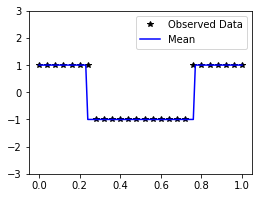

In [20]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize axes
f, ax = plt.subplots(1, 1, figsize=(4, 3))

with torch.no_grad():
    test_x = torch.linspace(0, 1, 101)
    predictions = likelihood(model(test_x))

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
pred_labels = predictions.mean.ge(0.5).float().mul(2).sub(1)
ax.plot(test_x.data.numpy(), pred_labels.numpy(), 'b')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])